<a href="https://colab.research.google.com/github/noraleilaa/460/blob/main/A_1_First_Vectorized_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 01 - First Vectorized Representation


Our goal in this exercise is to BEGIN coming to a common agreement, among this class, as to what terms we will use as we selectively refine our corpus-wide vocabulary. This corpus vocabulary is what would represent the content of each different document for clustering and classification purposes, which will be our next step. This means that we need to make decisions - what is in, what is out.

In [148]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [149]:
from google.colab import drive
# drive.mount('/content/gdrive/My Drive')
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


### NLTK Downloads

In [150]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [151]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [152]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [153]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Utility Functions

In [154]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []

    stop_words = set(nltk.corpus.stopwords.words('english'))
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))

    return result

def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
    data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
    data['is_action'] = data.index.isin(action_doc_ids)

def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

## Loading the corpus

In [155]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [156]:
# CORPUS_PATH = './data/MSDS453_Sec57_TestQA_ClassCorpus.csv'
# corpus_df = get_corpus_df(CORPUS_PATH)
# documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploritory Data Analysis

In [157]:
corpus_df.shape

(200, 9)

In [158]:
corpus_df.head(4).T

Doc_ID,90,91,92,93
DSI_Title,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Text,Target is on the move . '' Heavily outnumbered...,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen '' marks the third time th...,Improving through blandness . So Mike Banning ...
Submission File Name,LKP_Doc1_Angel_has_fallen,LKP_Doc2_Angel_has_fallen,LKP_Doc3_Angel_has_fallen,LKP_Doc4_Angel_has_fallen
Student Name,LKP,LKP,LKP,LKP
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen,Angel_has_fallen
Descriptor,Action_Angel_has_fallen_N_90,Action_Angel_has_fallen_N_91,Action_Angel_has_fallen_N_92,Action_Angel_has_fallen_N_93
Doc_ID,90,91,92,93


In [159]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [160]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


## Number of Reviews By Genre

In [161]:
counts_df = corpus_df[['Genre of Movie']].copy()
counts_df['Count'] = 1
counts_df.groupby(['Genre of Movie']).count().reset_index()

,Genre of Movie,Count
0,Action,50
1,Comedy,50
2,Horror,50
3,Sci-Fi,50


In [162]:
corpus_df.columns

Index(['DSI_Title', 'Text', 'Submission File Name', 'Student Name',
       'Genre of Movie', 'Review Type (pos or neg)', 'Movie Title',
       'Descriptor', 'Doc_ID'],
      dtype='object')

## Normalized Document

1. remove_punctuation(text)
2. lower_case(text)
3. remove_tags(text)
4. remove_special_chars_and_digits(text)
5. return Document(document.doc_id, text)

In [163]:
normalized_documents = normalize_documents(documents)
normalized_documents[0]

Document(doc_id=90, text='target is on the move heavily outnumbered and outgunned mike banning gerard butler strives to exit a multi level bullet riddled structure as squadrons of soldiers descend upon his position but thanks to his skills he s perfectly capable of overcoming the incredible odds or at least that s what the overwrought editing will have audiences assume in this opening sequence alone the camerawork is so shaky and hard to follow that it s impossible to know exactly what is going on back in washington d c banning awaits an offer to become the director of the secret service for president allan trumbull morgan freeman but despite his many years on the job working to protect the president from all sorts of mayhem mike is n t certain he s ready to sit behind a desk for the rest of his career his abuse of pills for migraines dizziness and insomnia does n t help in making the decision though his wife leah piper perabo and their infant daughter lynn would probably appreciate th

## Standardize Document

#### NLTK Tokenizer Package

https://www.nltk.org/api/nltk.tokenize.html

Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string:

### Functions for Tokenization Process
1. tokenize_document
2. tokenize_documents

In [164]:
tokenized_documents = tokenize_documents(normalized_documents)
tokenized_documents[0]

TokenizedDocument(doc_id=90, tokens=['target', 'is', 'on', 'the', 'move', 'heavily', 'outnumbered', 'and', 'outgunned', 'mike', 'banning', 'gerard', 'butler', 'strives', 'to', 'exit', 'a', 'multi', 'level', 'bullet', 'riddled', 'structure', 'as', 'squadrons', 'of', 'soldiers', 'descend', 'upon', 'his', 'position', 'but', 'thanks', 'to', 'his', 'skills', 'he', 's', 'perfectly', 'capable', 'of', 'overcoming', 'the', 'incredible', 'odds', 'or', 'at', 'least', 'that', 's', 'what', 'the', 'overwrought', 'editing', 'will', 'have', 'audiences', 'assume', 'in', 'this', 'opening', 'sequence', 'alone', 'the', 'camerawork', 'is', 'so', 'shaky', 'and', 'hard', 'to', 'follow', 'that', 'it', 's', 'impossible', 'to', 'know', 'exactly', 'what', 'is', 'going', 'on', 'back', 'in', 'washington', 'd', 'c', 'banning', 'awaits', 'an', 'offer', 'to', 'become', 'the', 'director', 'of', 'the', 'secret', 'service', 'for', 'president', 'allan', 'trumbull', 'morgan', 'freeman', 'but', 'despite', 'his', 'many', 'y

## Useful Lookups (Titles by DocID, Genres by DocID, Description by DocID)

In [165]:
titles_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Movie Title'])}
genres_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Genre of Movie'])}
descriptors_by_doc_ids = {x: y for x, y in zip(corpus_df['Doc_ID'], corpus_df['Descriptor'])}

action_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] == 'Action']
action_documents = [x for x in documents if x.doc_id in action_doc_ids]

non_action_doc_ids = {int(x) for x in corpus_df['Doc_ID'] if genres_by_doc_ids[x] != 'Action'}
non_action_documents = [x for x in documents if x.doc_id in non_action_doc_ids]

## Lookup for Specific Movie Title

In [166]:
print(corpus_df['Movie Title'].unique())

['Angel_has_fallen' 'Inception' 'No_Time_to_Die' 'Taken' 'Taxi' 'Barbie'
 'Dirty_Grandpa' 'Holmes_and_Watson' 'Lost City' 'Mean_Girls'
 'Drag_Me_To_Hell' 'Fresh' 'It_Chapter_Two' 'The Conjuring 2' 'The_Others'
 'EQUILIBRIUM' 'Minority_Report' 'Oblivion' 'Pitch_Black' 'The_Batman']


In [167]:
mean_girls_doc_ids = [int(x) for x in corpus_df['Doc_ID'] if titles_by_doc_ids[x] == 'Mean_Girls']
mean_girls_documents = [x for x in documents if x.doc_id in mean_girls_doc_ids]

mean_girls_doc_ids

[1, 2, 3, 4, 8, 0, 5, 6, 7, 9]

## Qualitative Term Determinations

#### Terms Determined by Document of Interest

In [168]:
candidate_terms = [
    'mean',
    'girls',
    'high',
    'plot',
    'fight',
    'bus',
    'africa',
    'lohan',
    'burn',
    'book',
    'female',
    'character',
    'popular',
    'spy',
    'school',
    'plastics',
    'friends',
    'clique'
]

## CountVectorizer

<div class="alert alert-block alert-success">
    <b>sklearn.feature_extraction.text.CountVectorizer</b>:<br>
Convert a collection of text documents to a matrix of token counts.<br>
This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.<br>
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.
</div>

In [169]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
text_for_counts = [x.text for x in normalized_documents]
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names_out()
word_counts = pd.DataFrame(matrix.toarray(), columns=words, index=corpus_df.Doc_ID)

In [170]:
add_flags(word_counts, mean_girls_doc_ids, action_doc_ids)
word_counts['Doc_ID'] = word_counts.index

In [171]:
# Collect result into a dataframe
mean_frequencies = pd.DataFrame(index=candidate_terms)

mean_girls_mean_frequencies = word_counts[word_counts.is_casino_royale][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['Mean_Girls'] = mean_girls_mean_frequencies

action_mean_frequencies = word_counts[word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Action'] = action_mean_frequencies

non_action_mean_frequencies = word_counts[~word_counts.is_action][[x for x in candidate_terms if x in word_counts.columns]].mean()
mean_frequencies['All Non-Action'] = non_action_mean_frequencies

In [172]:
image_2 = mean_frequencies
image_2

,Mean_Girls,All Action,All Non-Action
mean,2.10,0.16,0.22
girls,3.70,0.22,0.31
high,3.20,0.16,0.40
plot,0.00,0.78,0.22
fight,0.10,0.18,0.08
bus,0.00,0.00,0.01
africa,0.80,0.00,0.05
lohan,1.80,0.00,0.12
burn,0.00,0.00,0.01
book,0.90,0.02,0.29


In [173]:
image_2.to_csv('prt_1_i_2.csv')

In [174]:
from PIL import Image


image_3 = mean_frequencies.fillna(0.0).sort_values(['Mean_Girls'], ascending=False)


image_3.to_csv('prt_1_i_3.csv')

In [175]:
image_3

,Mean_Girls,All Action,All Non-Action
school,5.10,0.02,0.42
girls,3.70,0.22,0.31
high,3.20,0.16,0.40
mean,2.10,0.16,0.22
lohan,1.80,0.00,0.12
plastics,1.50,0.00,0.10
friends,1.10,0.10,0.15
book,0.90,0.02,0.29
africa,0.80,0.00,0.05
popular,0.70,0.02,0.07


In [176]:
# These are identified
important_prevalent_terms = [
    'school',
    'girls',
    'high',
    'mean'
]
stemmer = PorterStemmer()
stemmed_important_prevalent_terms = [stemmer.stem(x) for x in important_prevalent_terms]

stemmed_important_prevalent_terms


['school', 'girl', 'high', 'mean']

In [177]:
pd.options.display.float_format = '{:,.2f}'.format

image_1 = mean_frequencies.fillna(0.0).loc[important_prevalent_terms].round(2).sort_values(['Mean_Girls'], ascending=False)

image_1
image_1.to_csv('prt_1_i_1.csv')

In [178]:
image_1

,Mean_Girls,All Action,All Non-Action
school,5.10,0.02,0.42
girls,3.70,0.22,0.31
high,3.20,0.16,0.40
mean,2.10,0.16,0.22


## TF-IDF Experiment Functions - Text Normalization

In [179]:
def run_tfidf(documents: List[Document],
              clean_func: Callable[[List[Document]], List[TokenizedDocument]],
              important_prevalent_terms: List[str],
              experiment_name: str,
              output_tfidf_vectors: bool=False,
              output_vocabulary: bool=True):
    cleaned_documents = clean_func(documents)
    cleaned_document_text = [' '.join(x.tokens) for x in cleaned_documents]

    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()

    output_dir = f'output/{experiment_name}_Results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if output_tfidf_vectors:
        for counter, doc in enumerate(transformed_documents_as_array):
            tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), doc))
            one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score'])\
                                        .sort_values(by='score', ascending=False)\
                                        .reset_index(drop=True)

            one_doc_as_df.to_csv(f'{output_dir}/{corpus_df["Submission File Name"][counter]}')

    if output_vocabulary:
        with open(f'{output_dir}/vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names_out())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix,
                               columns=vectorizer.get_feature_names_out(),
                               index=corpus_df.Doc_ID)
    add_flags(doc_term_df, mean_girls_doc_ids, action_doc_ids)

    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)

    # Collect result into a dataframe
    tfidf_results = pd.DataFrame(index=important_prevalent_terms)

    all_tfidf_results = doc_term_df[[x for x in important_prevalent_terms if x in doc_term_df.columns]].mean().round(2)
    tfidf_results['All Movies'] = all_tfidf_results

    plt.hist(doc_term_df.mean(), 100, range=(0, 8))

    print(f'Vocabulary size: {doc_term_df.shape[1]}')

    descriptors = corpus_df['Descriptor']

    similarities = cosine_similarity(doc_term_df.loc[action_doc_ids], doc_term_df.loc[action_doc_ids])
    fig, ax = plt.subplots(figsize=(30, 30))
    labels = [descriptors_by_doc_ids[x.doc_id] for x in action_documents]

    sns.heatmap(ax=ax, data=similarities, xticklabels=labels, yticklabels=labels)
    #plt.savefig(f'figures/{experiment_name}_heatmap_documents.png')
    plt.show()

## TF-IDF  (Term Frequency-Inverse Document Frequency)

### Experiments, Normalize, Tokenize, Lemmatization and Stop Word Removal

In [180]:
def clean_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes, lemmatizes, and removes stop words.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    documents = stem(documents)

    return documents

,Mean TF-IDF
film,3.57
movi,3.07
wa,2.59
ha,2.48
like,2.15
one,1.94
time,1.83
charact,1.67
barbi,1.66
bond,1.55


Vocabulary size: 7772


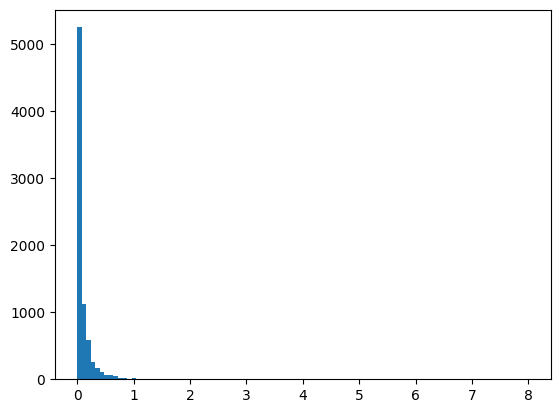

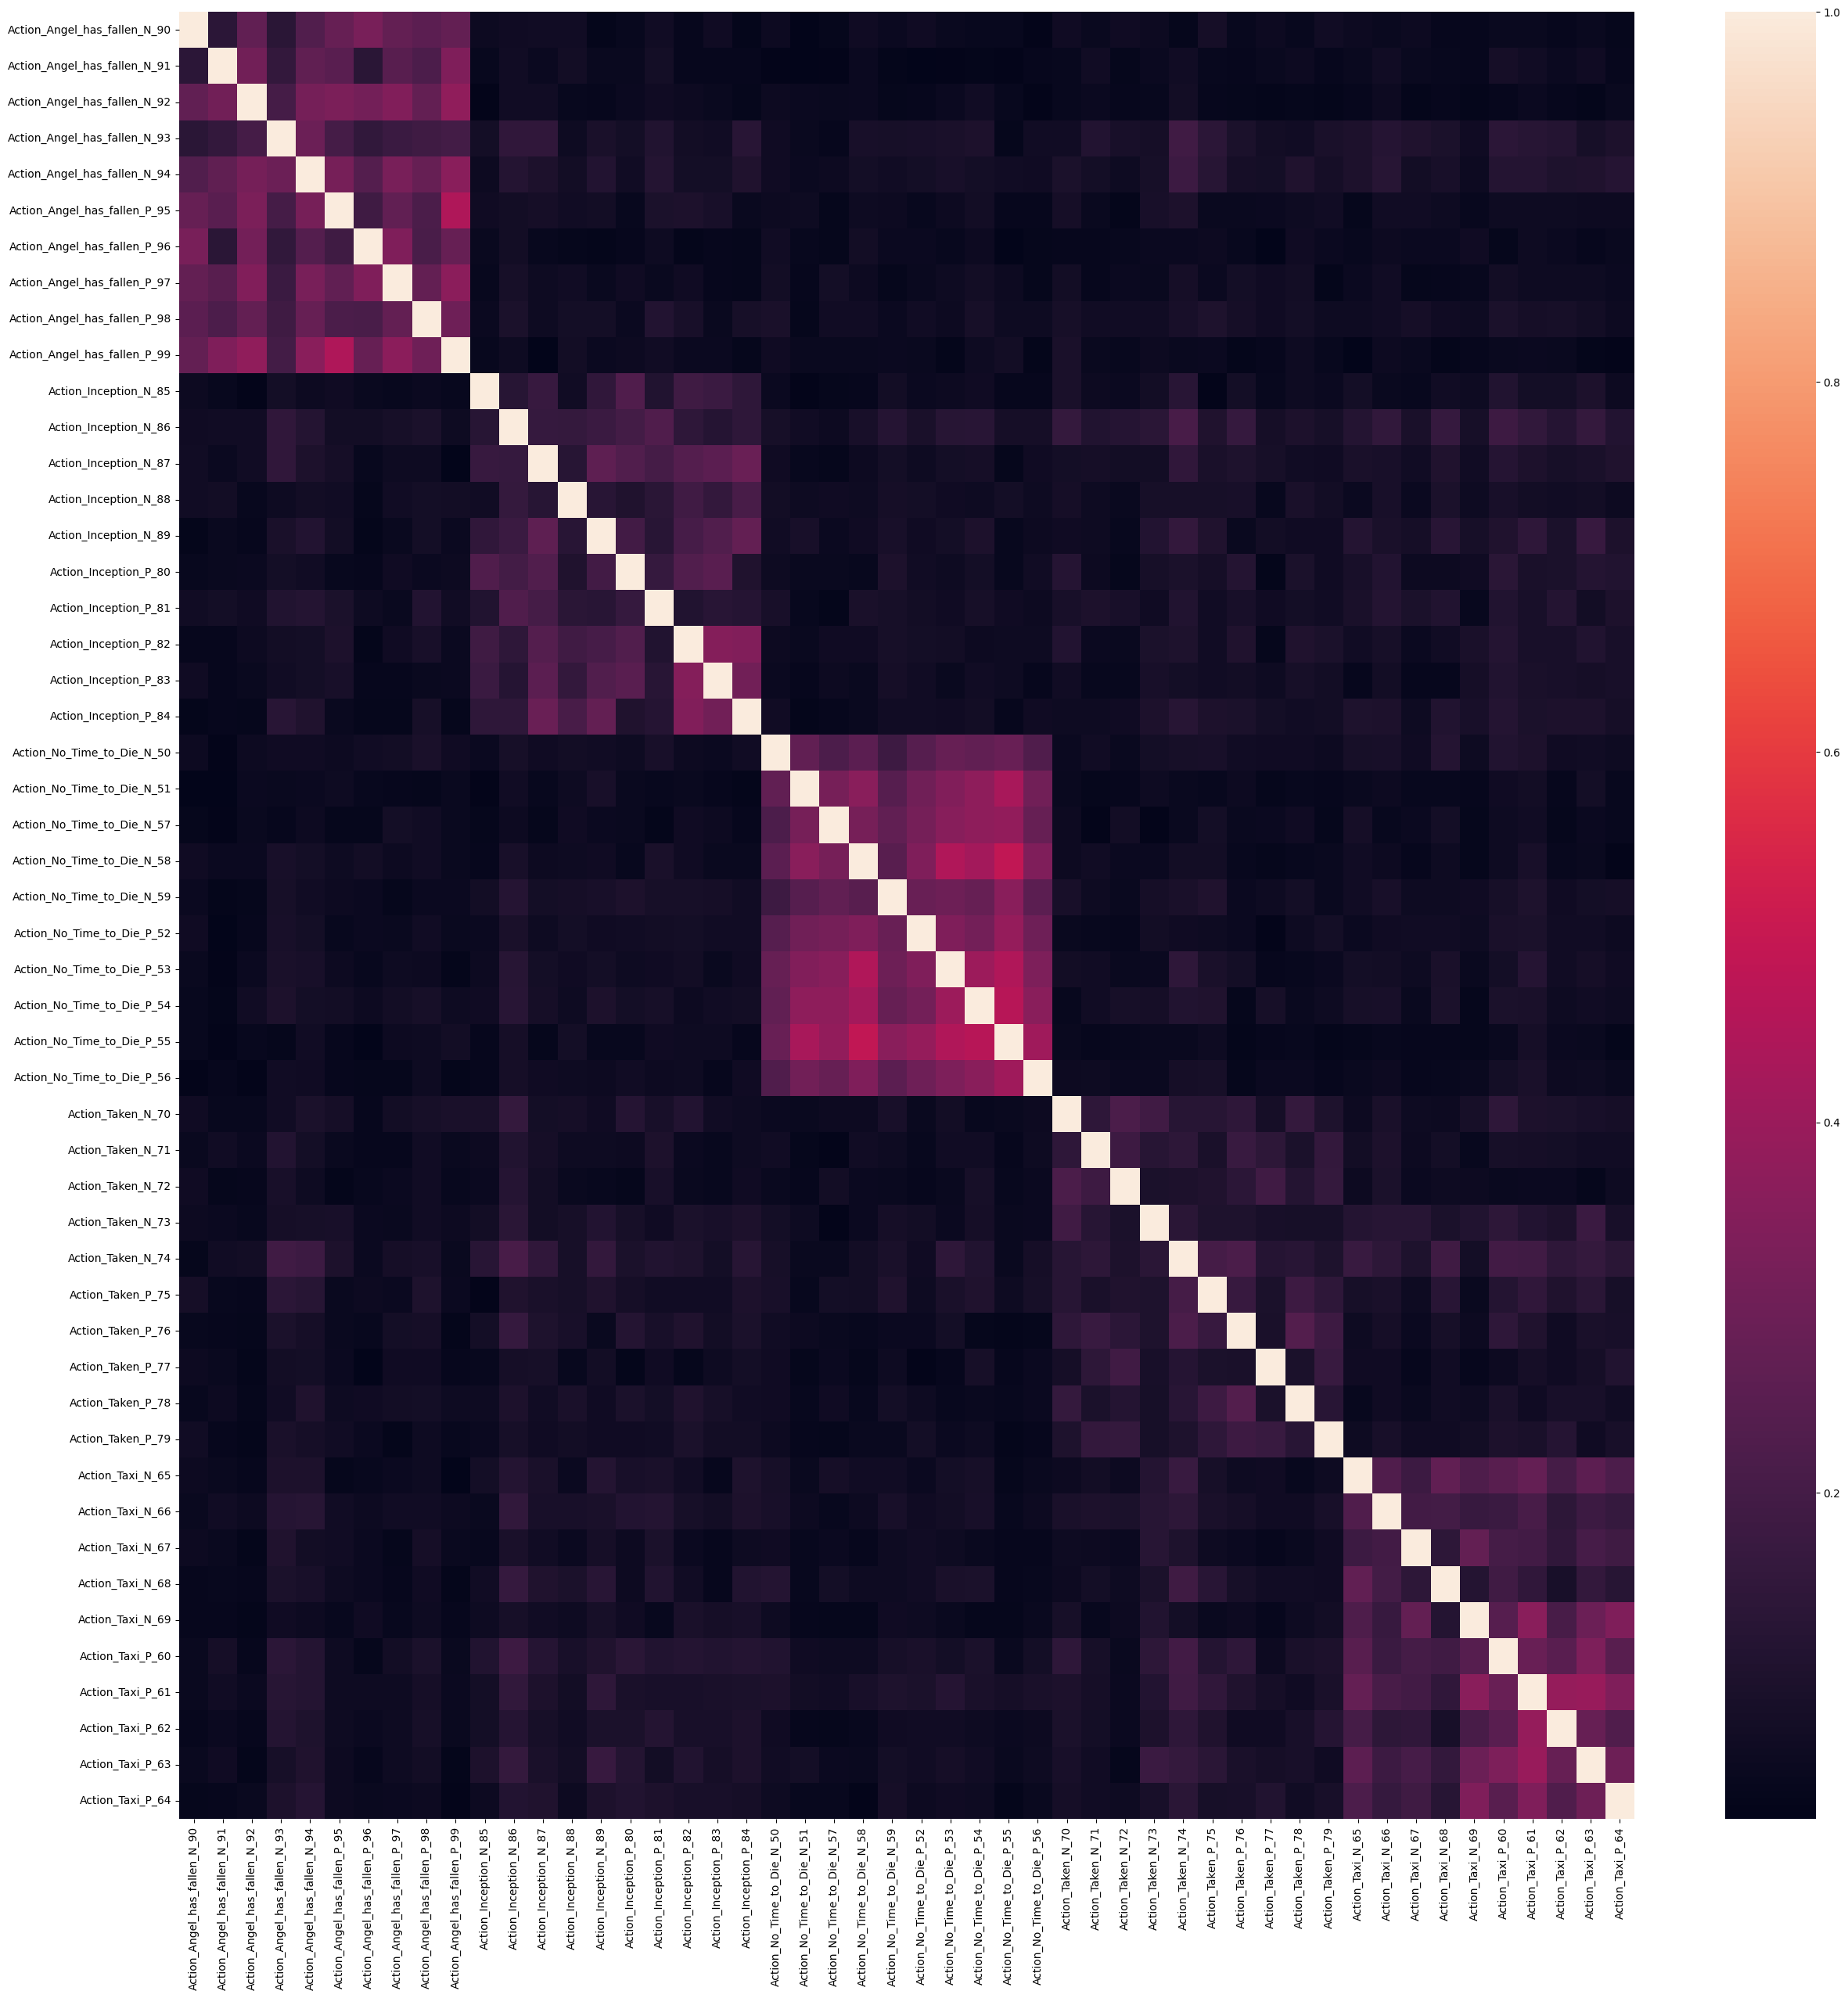

In [181]:
p_2_i_1 = run_tfidf(documents, clean_method, important_prevalent_terms, 'TFIDF_exp')
p_2_i_1



## Word2Vec

<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

## Utility Functions For Word2Vec Experiments

In [182]:
def get_word2vec_vectors(documents: List[TokenizedDocument], embedding_size: int) -> pd.DataFrame:
    tokens = [x.tokens for x in documents]

    # https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

    # gensim 3.8
    #word2vec_model = Word2Vec(tokens, size=embedding_size, window=3, min_count=1, workers=12)

    # gensim 4.3.1
    word2vec_model = Word2Vec(sentences=tokens, vector_size=embedding_size, window=3, min_count=1, workers=12)

    # gensim 3.8
    #vectors = {}
    #for i in word2vec_model.wv.vocab:
    #    temp_vec = word2vec_model.wv[i]
    #    vectors[i] = temp_vec

    # gensim 4.3.1
    vectors = {}
    for i in word2vec_model.wv.index_to_key:
        temp_vec = word2vec_model.wv[i]
        vectors[i] = temp_vec

    # Changes made:
    #   1. The size parameter in Word2Vec has been renamed to vector_size.
    #   2. Instead of iterating through word2vec_model.wv.vocab, you should now use
    #      word2vec_model.wv.index_to_key to get the list of words in the vocabulary.


    result = pd.DataFrame(vectors).transpose()
    result = result.sort_index()
    return result

def plot_similarity_matrix(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ax=ax, data=similarities, xticklabels=data.index, yticklabels=data.index);
    #plt.savefig(f'figures/{experiment_name}_heatmap.png')
    plt.close()

def plot_similarity_clustermap(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    cm = sns.clustermap(similarities, metric='cosine', xticklabels=data.index, yticklabels=data.index, method='complete', cmap='RdBu', figsize=figsize)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    plt.legend(loc='upper left')
    #plt.savefig(f'figures/{experiment_name}_clustermap.png')
    plt.show()
    plt.close()

def plot_tsne(data: pd.DataFrame, perplexity: int, experiment_name: str, figsize=(40, 40)):
    """
    Creates a TSNE plot of the supplied dataframe
    """
    tsne_model = TSNE(perplexity=perplexity, n_components=2, learning_rate='auto', init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    labels = list(data.index)
    for i in range(len(x)):
        new_value = new_values[i]
        x = new_value[0]
        y = new_value[1]

        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.savefig(f'figures/{experiment_name}_tsne.png')
    plt.show()
    plt.close()

def run_word2vec_experiment(documents: List[Document],
                            clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                            embedding_size: int,
                            chosen_tokens: List[str],
                            experiment_name: str):
    cleaned_documents = clean_func(documents)

    word2vec_df = get_word2vec_vectors(cleaned_documents, embedding_size)
    filtered_word2vec_df = word2vec_df.loc[chosen_tokens].copy()

    plot_tsne(filtered_word2vec_df, 30, experiment_name)
    plot_similarity_matrix(filtered_word2vec_df, experiment_name)
    plot_similarity_clustermap(filtered_word2vec_df, experiment_name)

In [183]:
#I did not understand the importance of this code and thereffore did not touch it
extra_terms = [
    'bond',
    'craig',
    'star',
    'casino',
    'action'
]


In [184]:
# Get our terms to examine in experiements 4-12
all_tokens = get_all_tokens(remove_stop_words(clean_method(documents)))
chosen_tokens = random.choices(all_tokens, k=100 - len(extra_terms)) + extra_terms

lemmatizer = WordNetLemmatizer()
lemmatized_chosen_tokens = [lemmatizer.lemmatize(x) for x in chosen_tokens]
stemmed_chosen_tokens = [stemmer.stem(x) for x in lemmatized_chosen_tokens]

## Word2Vec Experiments:


<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

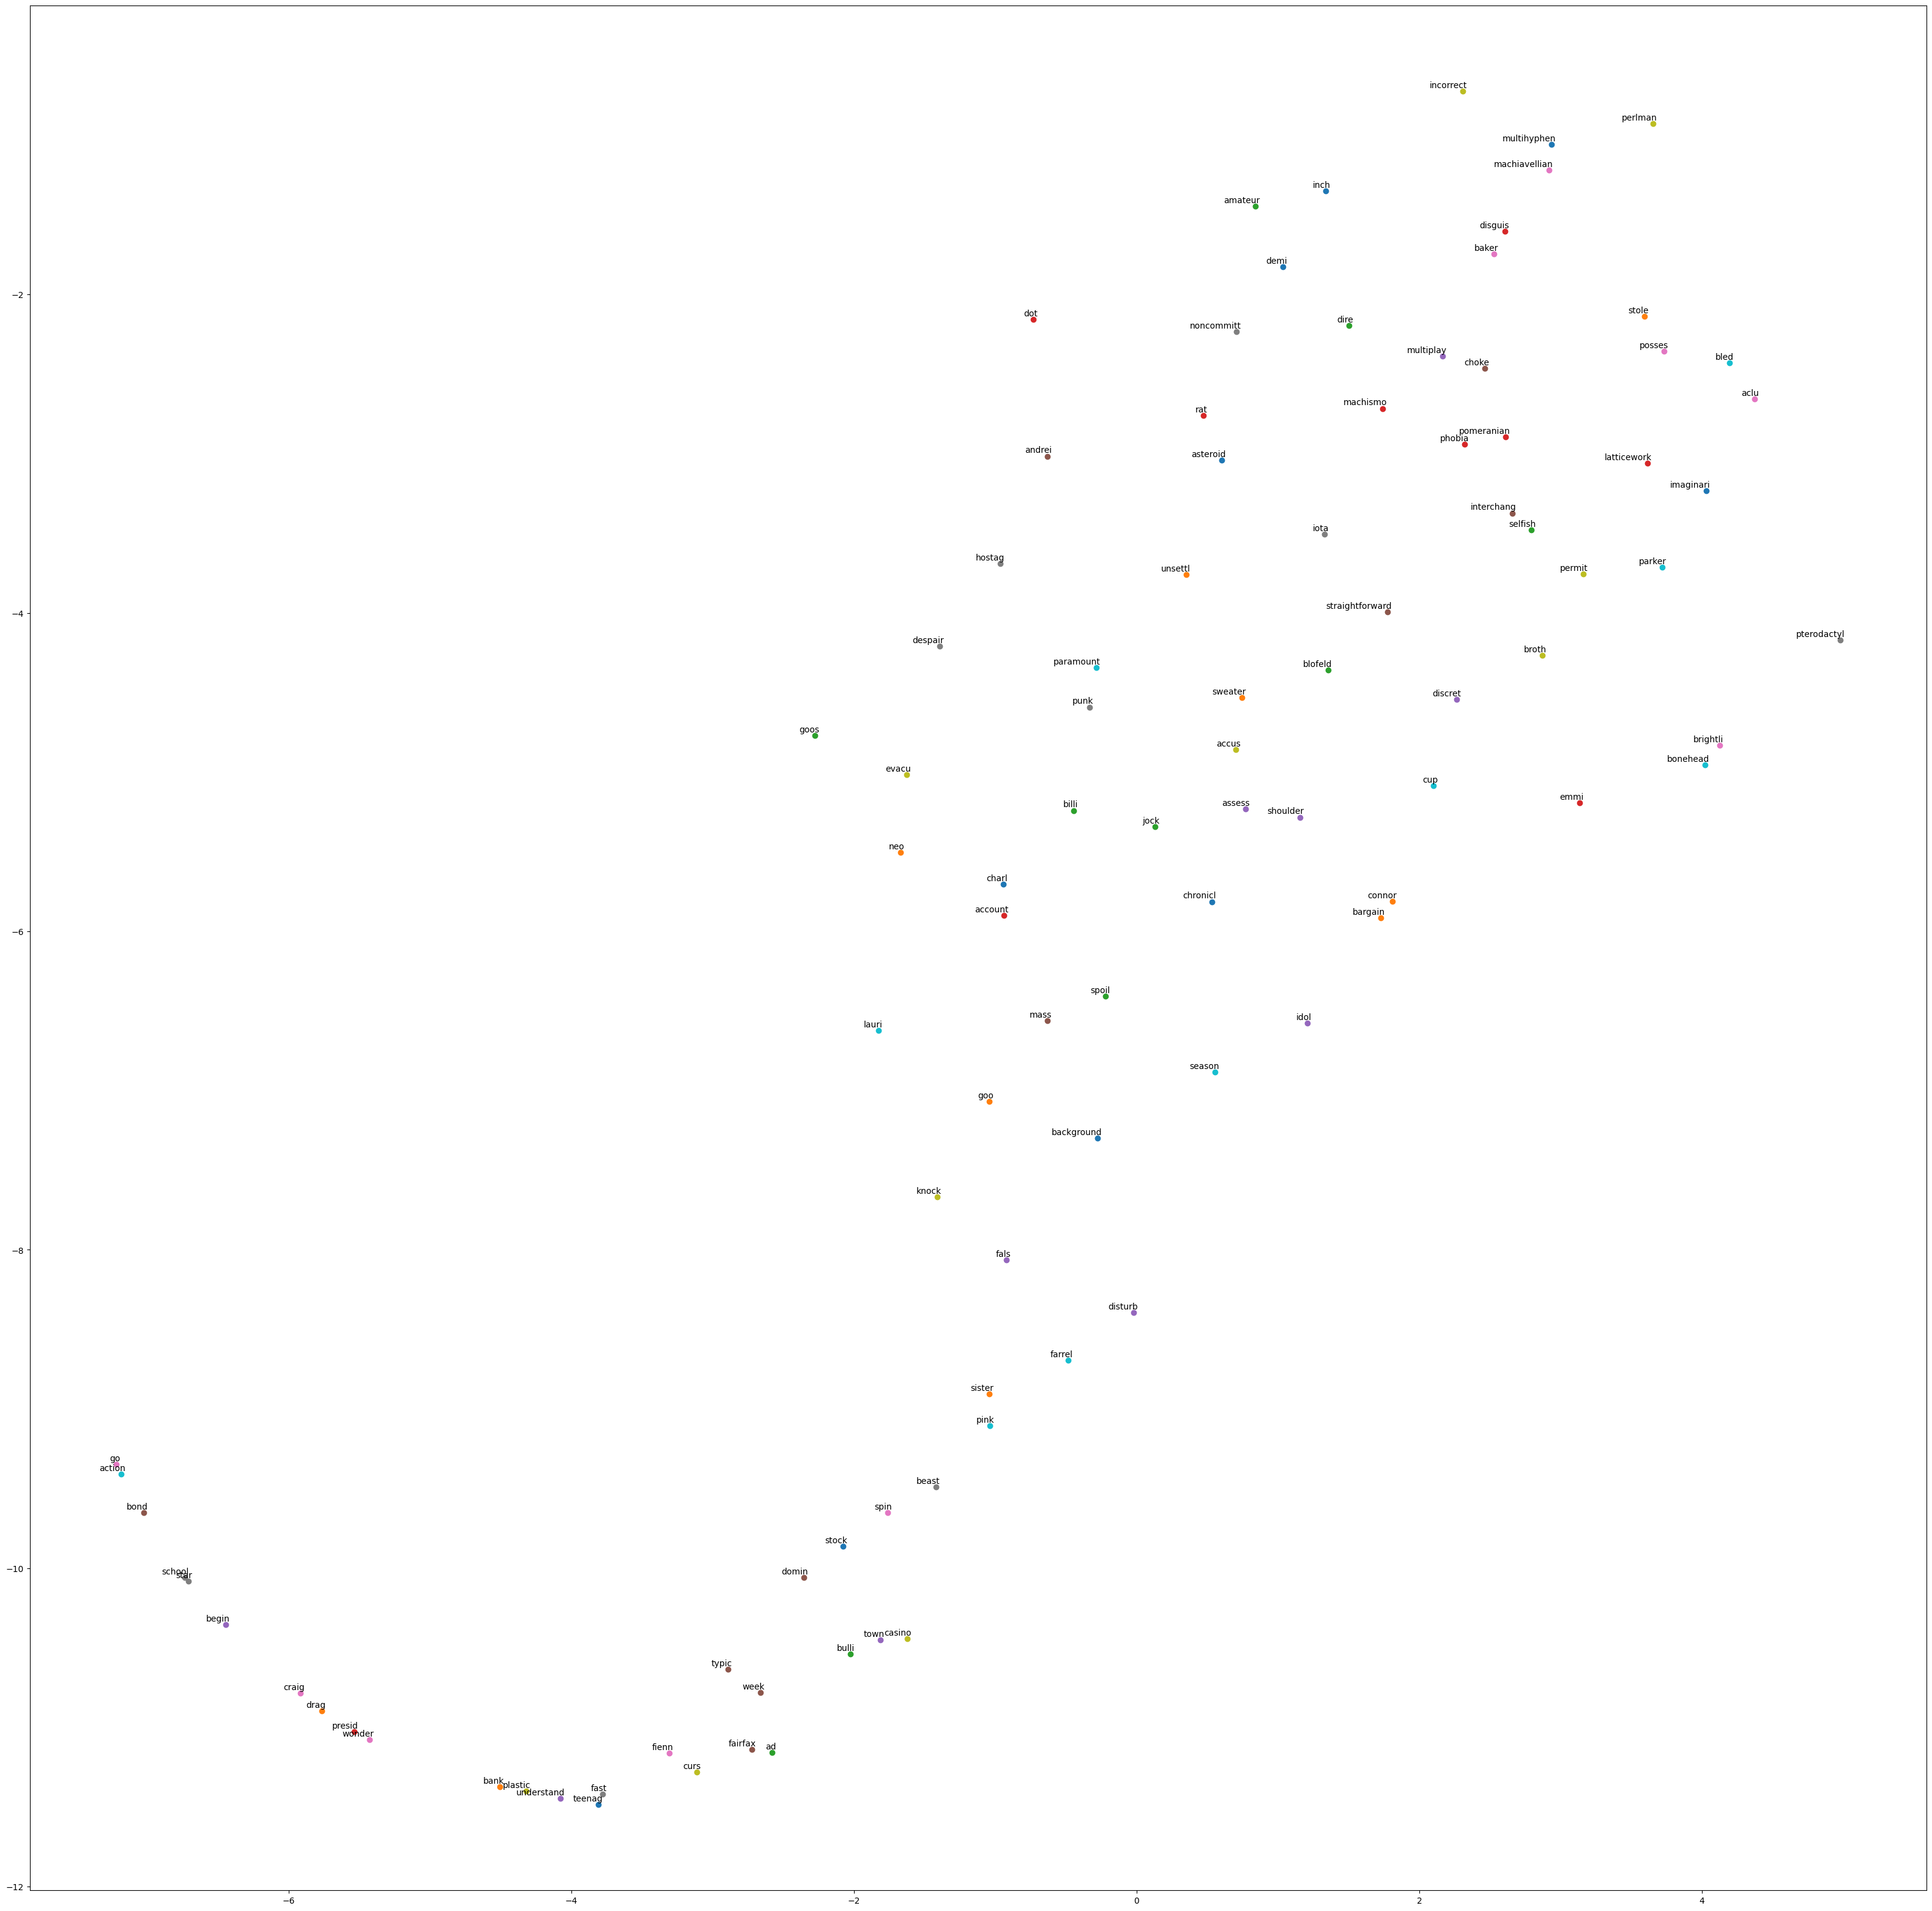

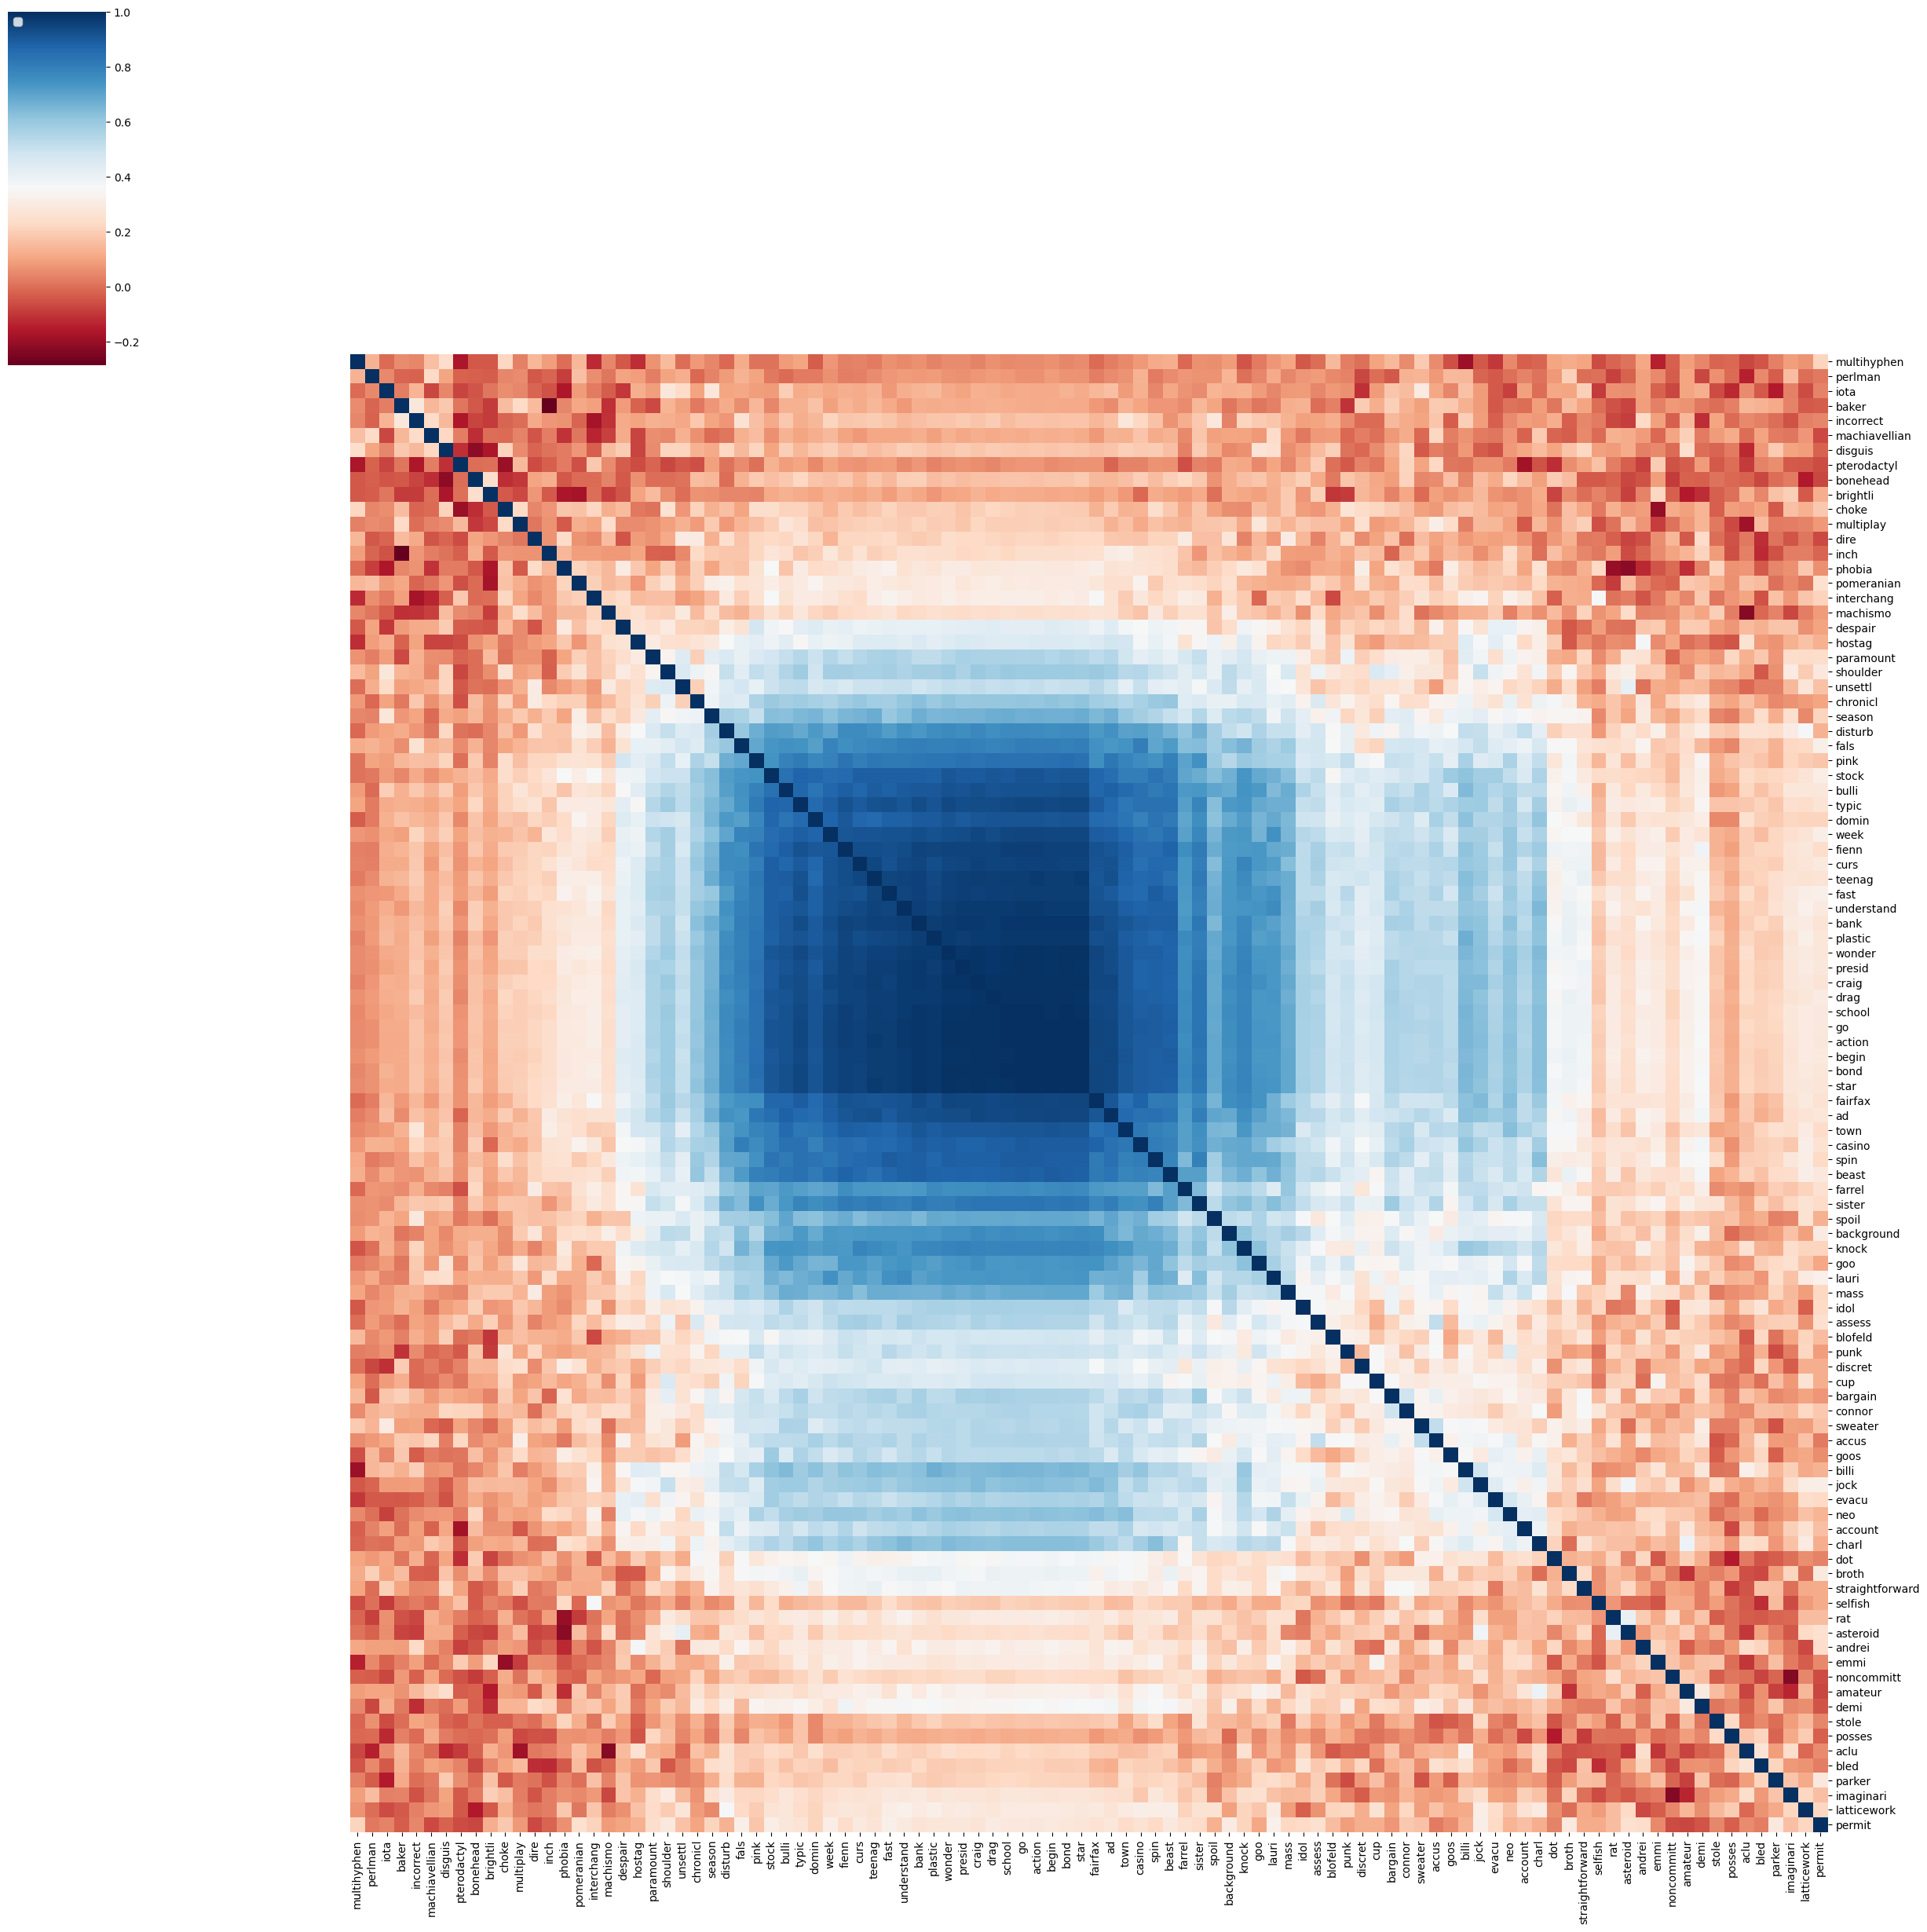

In [185]:
run_word2vec_experiment(documents, clean_method, 100, chosen_tokens, 'Word2Vec_exp')

## Utility functions for Doc2Vec experiments

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

In [186]:
def run_doc2vec(documents: List[TokenizedDocument], embedding_size: int, descriptors_by_doc_ids: Dict[int, str]):
    tagged_documents = [TaggedDocument(document.tokens, [i]) for i, document in enumerate(documents)]
    doc2vec_model = Doc2Vec(tagged_documents, vector_size=embedding_size, window=3, min_count=2, workers=12)

    doc2vec_df = pd.DataFrame()
    for document in documents:
        vector = pd.DataFrame(doc2vec_model.infer_vector(document.tokens)).transpose()
        doc2vec_df = pd.concat([doc2vec_df, vector], axis=0)

    doc2vec_df['Descriptor'] = [descriptors_by_doc_ids[x.doc_id] for x in documents]
    doc2vec_df.set_index(['Descriptor'], inplace=True)
    return doc2vec_df

def run_doc2vec_experiment(documents: List[Document],
                           clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                           embedding_size: int,
                           experiment_name: str):
    cleaned_documents = clean_func(documents)
    doc2vec_df = run_doc2vec(cleaned_documents, embedding_size, descriptors_by_doc_ids)

    plot_similarity_matrix(doc2vec_df, experiment_name)
    plot_similarity_clustermap(doc2vec_df, experiment_name, figsize=(50, 50))
    plot_tsne(doc2vec_df, 30, experiment_name)

## Doc2Vec Experiments:

<div class="alert alert-block alert-success">
    <b>Doc2vec Paragraph Embeddings</b>: https://radimrehurek.com/gensim/models/doc2vec.html <br>
    Paragraph and document embeddings via the distributed memory and distributed bag of words models from Quoc Le and Tomas Mikolov: “Distributed Representations of Sentences and Documents”. <br>

The algorithms use either hierarchical softmax or negative sampling;
            </div>

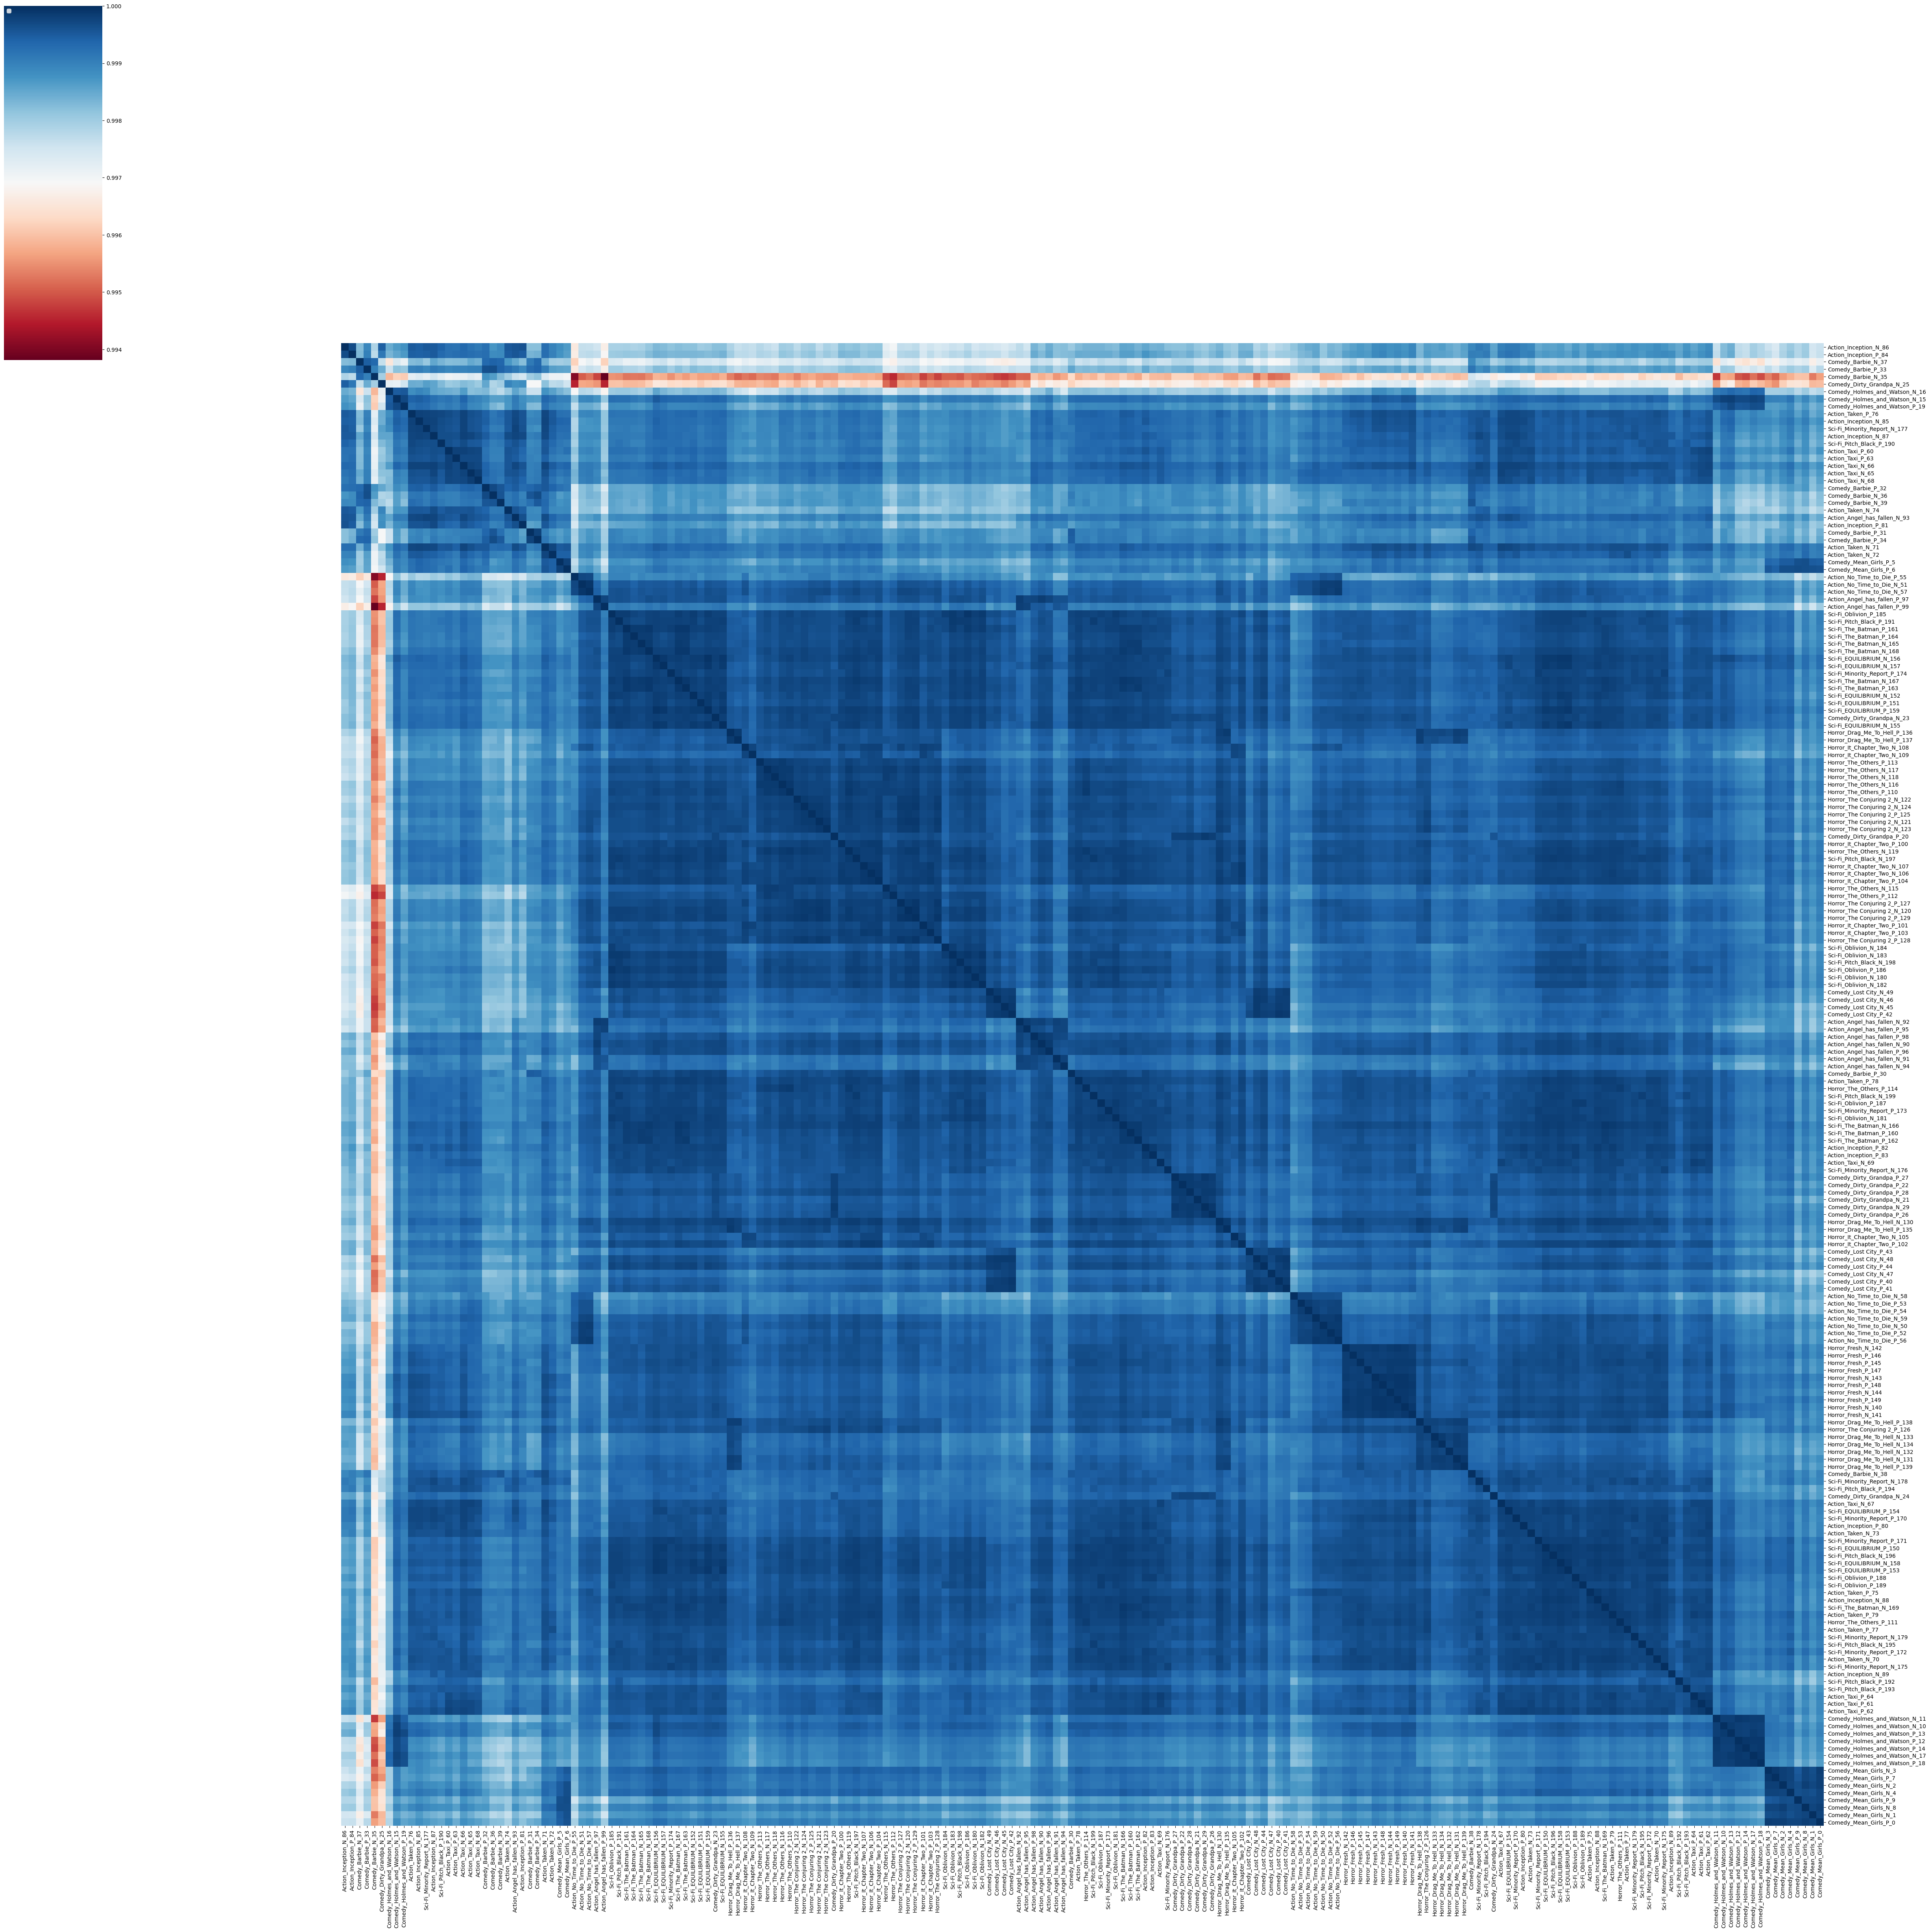

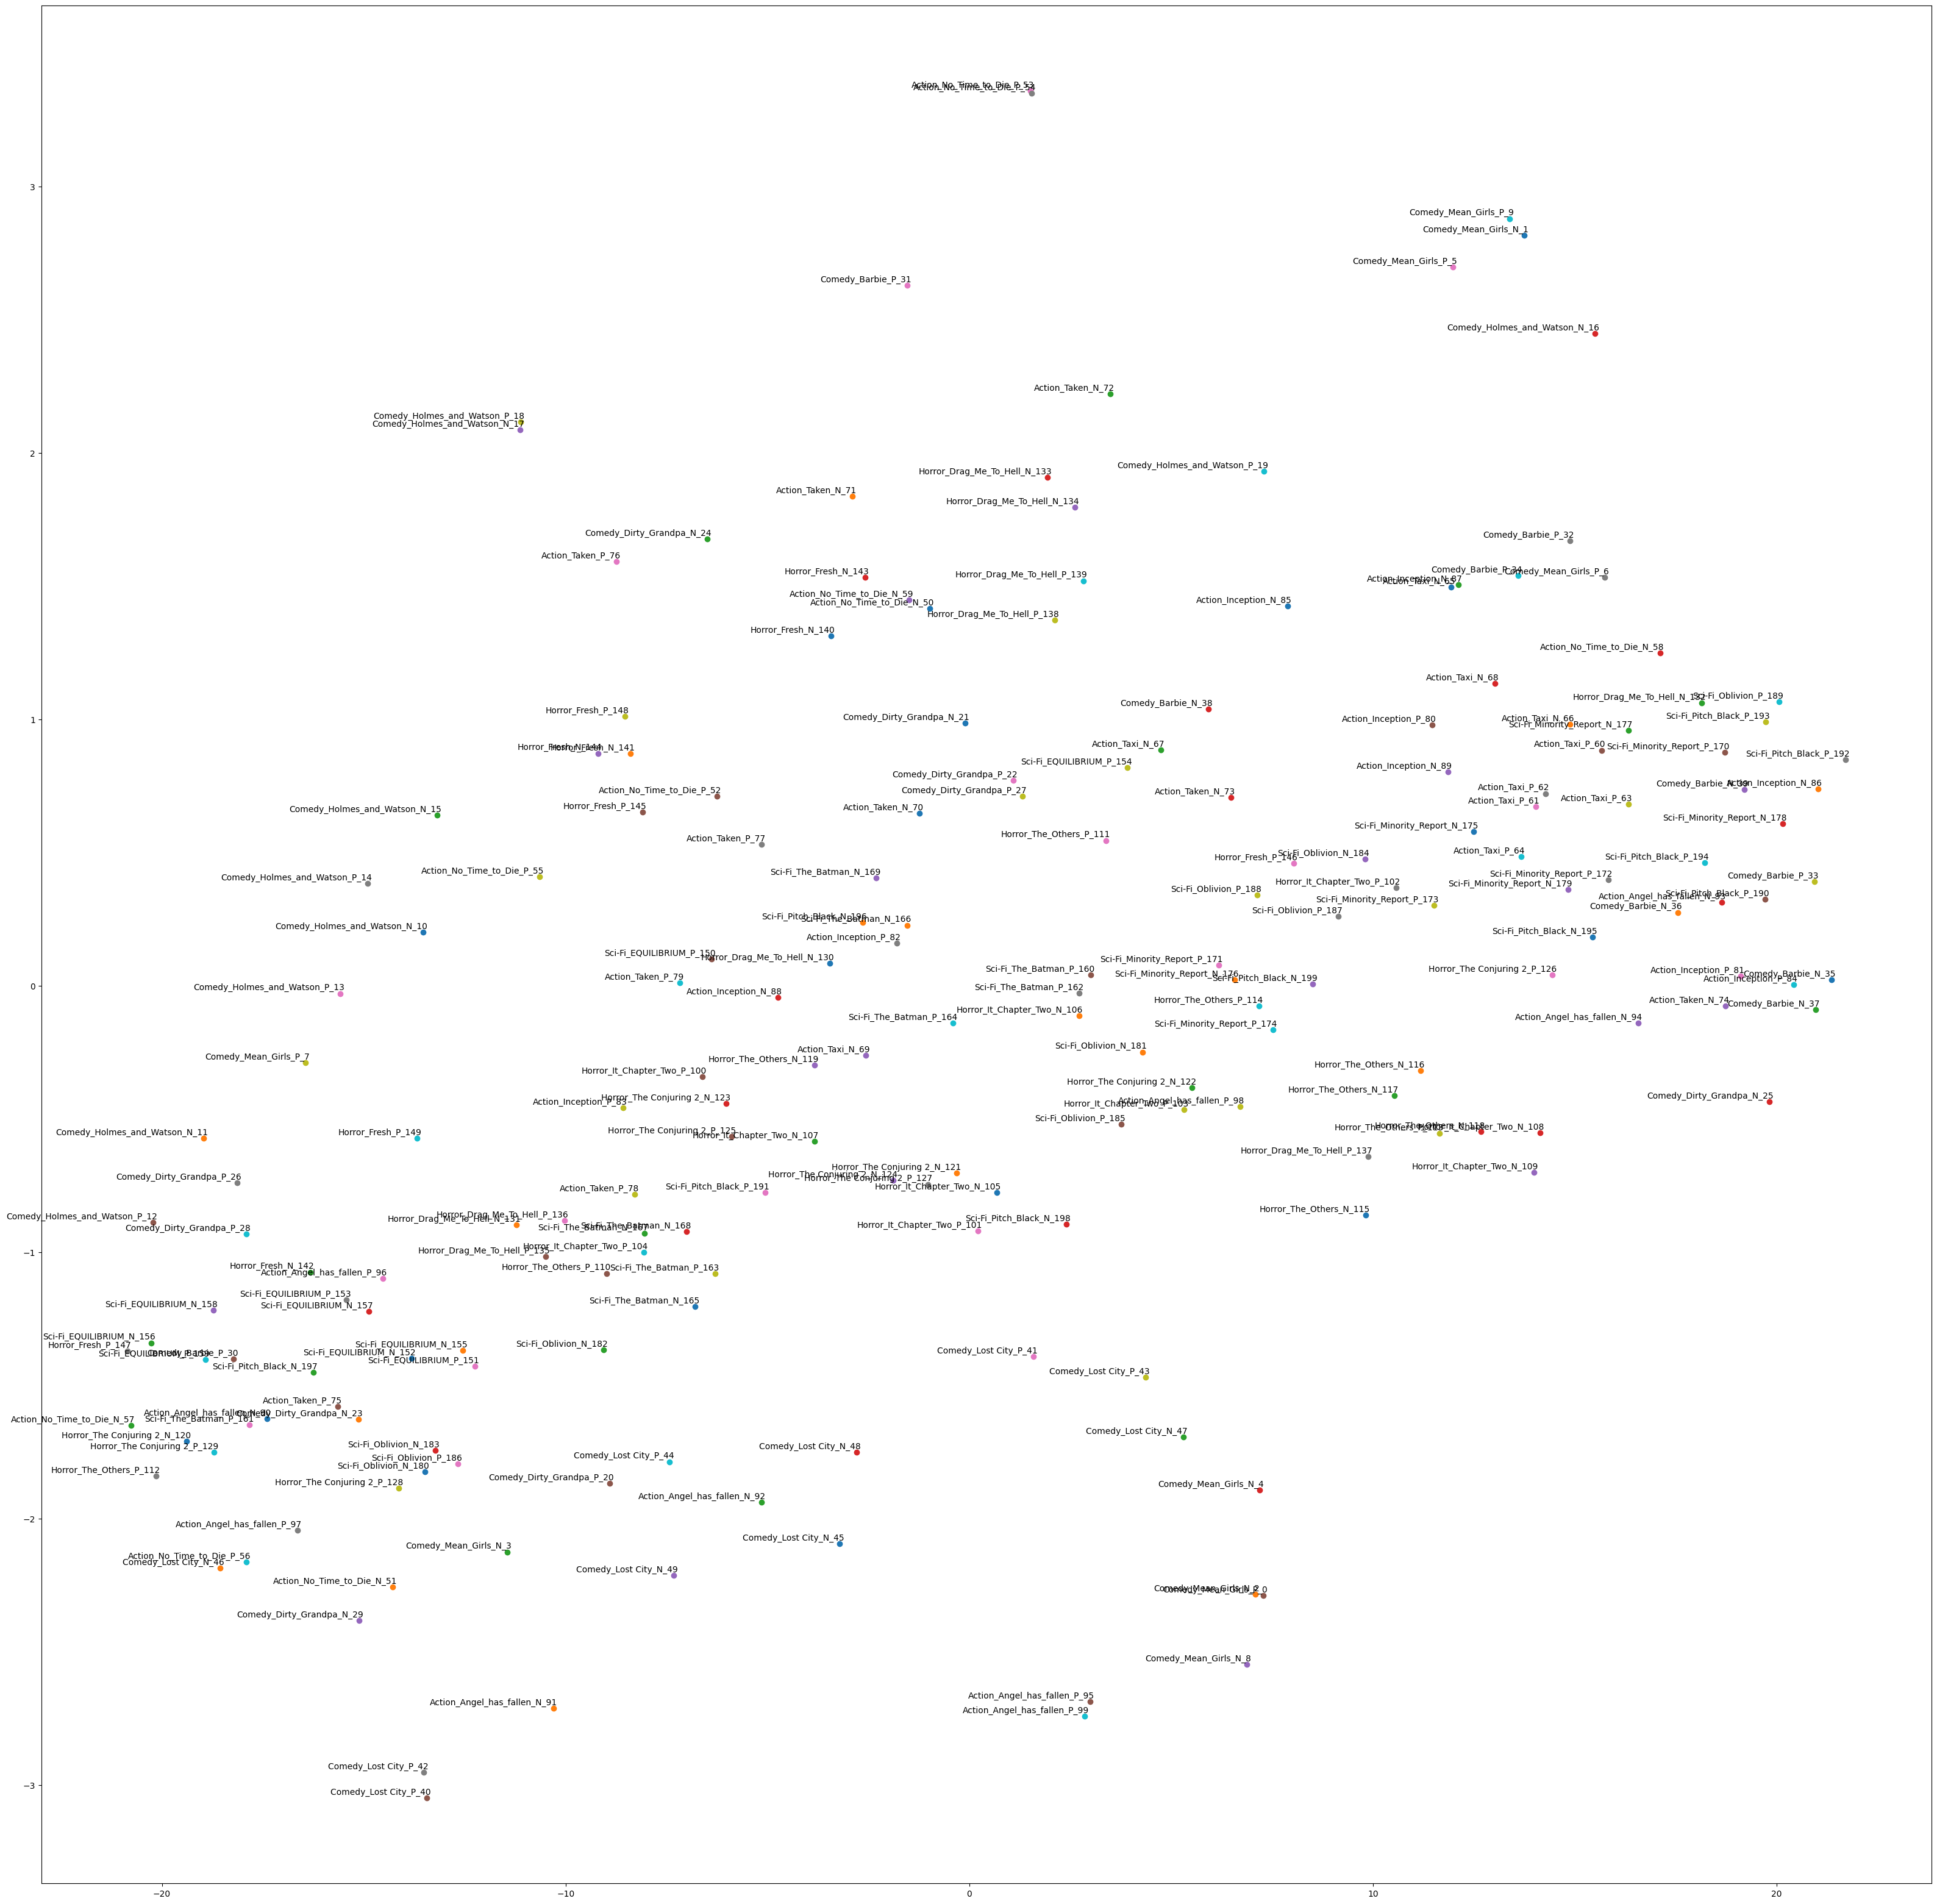

In [187]:
run_doc2vec_experiment(documents, clean_method, 100, 'Doc2Vec_exp')


In [188]:
# Placeholder for the Document class
class Document:
    def __init__(self, doc_id, text):
        self.doc_id = doc_id
        self.text = text

# Placeholder for the tokenize_documents function
def tokenize_documents(text_data):
    # Implement your tokenization logic here
    pass

# Placeholder for the lemmatize function
def lemmatize(tokenized_documents):
    # Implement your lemmatization logic here
    pass

# Placeholder for the stem function (if needed)
def stem(lemmatized_documents):
    # Implement your stemming logic here
    pass

# Placeholder for the remove_stop_words function
def remove_stop_words(lemmatized_documents):
    # Implement your stop words removal logic here
    pass

# Placeholder for your text data
text_data = [
    "This is the first document.",
    "This is the second document.",
    # Add more documents here
]

# Create Document objects with unique identifiers
documents = [Document(f"Doc_{idx}", text) for idx, text in enumerate(text_data)]

# Tokenize the documents
tokenized_documents = tokenize_documents([document.text for document in documents])

# Lemmatize the tokenized documents
lemmatized_documents = lemmatize(tokenized_documents)


documents_without_stopwords = remove_stop_words(lemmatized_documents)


In [189]:
documents_without_stopwords

In [190]:
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import pandas as pd
from collections import Counter
import numpy as np

# Load your data using Pandas, assuming you have a DataFrame called 'corpus_df' with a 'Text' column.
# Replace 'your_data.csv' with the actual path to your dataset.

def baseline(text):
    return text

def baseline_with_lemmatization_and_stopwords(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return ' '.join(tokens)

def custom_data_wrangling(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove stop words and custom stop words
    stop_words = set(stopwords.words('english'))
    custom_stop_words = set(["film", "movie"])  # Add custom stop words here
    tokens = [token for token in tokens if token not in stop_words and token not in custom_stop_words]

    # Remove non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha()]

    return ' '.join(tokens)


In [191]:
# Define TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Perform experiments
data_wrangling_methods = [baseline, baseline_with_lemmatization_and_stopwords, custom_data_wrangling]
embedding_dimensions = [100, 200, 300]


In [192]:
experiment_results = []

for data_wrangling_method in data_wrangling_methods:
    for embedding_dim in embedding_dimensions:
        # Extract text content from processed documents
        document_texts = [doc.text for doc in documents]

        # TF-IDF Vectorization
        tfidf_matrix = tfidf_vectorizer.fit_transform(document_texts)

        # Word2Vec Embedding
        word2vec_model = Word2Vec(sentences=[word_tokenize(doc) for doc in document_texts],
                                  vector_size=embedding_dim,
                                  window=5,
                                  min_count=1,
                                  sg=0)

        # Doc2Vec Embedding
        tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(document_texts)]
        doc2vec_model = Doc2Vec(vector_size=embedding_dim, window=5, min_count=1, epochs=100)
        doc2vec_model.build_vocab(tagged_data)
        doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

        # Store results or perform additional analysis here

        # Experiment summary (modify as needed)
        experiment_summary = {
            'Data Wrangling Method': data_wrangling_method.__name__,
            'Embedding Dimension': embedding_dim,
            'TF-IDF Matrix': tfidf_matrix,  # Store TF-IDF matrix
            'Word2Vec Model': word2vec_model,  # Store Word2Vec model
            'Doc2Vec Model': doc2vec_model  # Store Doc2Vec model
        }

        experiment_results.append(experiment_summary)


In [193]:
experiment_summary

{'Data Wrangling Method': 'custom_data_wrangling',
 'Embedding Dimension': 300,
 'TF-IDF Matrix': <2x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 10 stored elements in Compressed Sparse Row format>,
 'Word2Vec Model': <gensim.models.word2vec.Word2Vec at 0x7e09a938cc40>,
 'Doc2Vec Model': <gensim.models.doc2vec.Doc2Vec at 0x7e09a938ca90>}